In [1]:
%pip install tensorflow tensorflow_decision_forests


[notice] A new release of pip is available: 23.3 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import opendatasets as od
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np


import tensorflow as tf
import tensorflow_decision_forests as tfdf


plt.style.use("bmh")

In [3]:
od.download("https://www.kaggle.com/datasets/surajjha101/cuisine-rating")
dataset_df = pd.read_csv('./cuisine-rating/Cuisine_rating.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Skipping, found downloaded files in "./cuisine-rating" (use force=True to force download)
Full train dataset shape is (200, 15)


In [4]:
dataset_df = dataset_df.drop(["User ID", "Location"], axis=1)

# little reindexing to cut off ratings by [:-3] inxexing
col_list = list(dataset_df)
col_list[-1], col_list[-4] = col_list[-4], col_list[-1]
dataset_df = dataset_df.reindex(columns=col_list)
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area code       200 non-null    int64  
 1   Gender          200 non-null    object 
 2   YOB             200 non-null    int64  
 3   Marital Status  200 non-null    object 
 4   Activity        200 non-null    object 
 5   Budget          200 non-null    int64  
 6   Cuisines        200 non-null    object 
 7   Alcohol         200 non-null    object 
 8   Smoker          200 non-null    object 
 9   Often A S       200 non-null    object 
 10  Service Rating  200 non-null    int64  
 11  Overall Rating  200 non-null    float64
 12  Food Rating     200 non-null    int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 20.4+ KB


In [5]:
dataset_df

,Area code,Gender,YOB,Marital Status,Activity,Budget,Cuisines,Alcohol,Smoker,Often A S,Service Rating,Overall Rating,Food Rating
0,153,Female,2006,Single,Professional,3,Japanese,Never,Never,No,4,4.5,5
1,123,Female,1991,Married,Student,3,Indian,Never,Socially,No,1,1.0,1
2,122,Male,1977,Single,Student,5,Seafood,Often,Often,Yes,5,5.0,5
3,153,Female,1956,Married,Professional,5,Japanese,Never,Socially,No,1,2.0,3
4,129,Male,1997,Single,Student,4,Filipino,Socially,Never,No,4,3.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,175,Female,1982,Single,Professional,4,French,Never,Socially,No,2,1.5,1
196,170,Female,2000,Married,Student,4,Chinese,Never,Often,No,2,1.5,1
197,160,Female,2006,Single,Professional,5,Japanese,Never,Often,No,2,3.5,5
198,130,Male,2002,Married,Student,3,Filipino,Never,Socially,No,2,2.5,3


<Axes: ylabel='Count'>

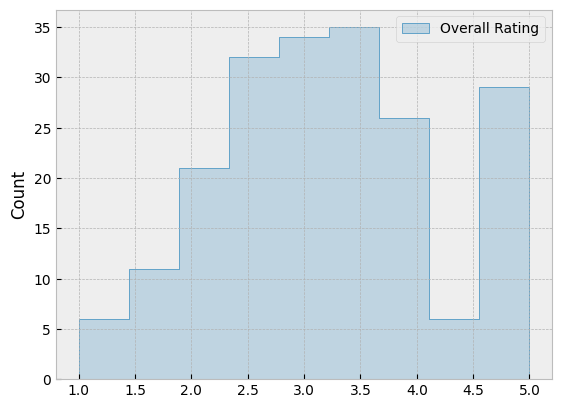

In [6]:
sns.histplot(data=dataset_df[["Overall Rating"]], element="step")

In [7]:
num_dataset = dataset_df.copy()
for col in num_dataset:
    if num_dataset[col].dtype in ["int64", "float64"]:
        continue
    num_dataset[col] = num_dataset[col].rank().astype(int)

In [8]:
dataset_corr = num_dataset.corr()["Overall Rating"][:-3]

real_features = dataset_corr[abs(dataset_corr) > 0.5].sort_values(ascending=False)
real_features

Series([], Name: Overall Rating, dtype: float64)

Всего 200 записей, похоже будет сложно получить хорошее предсказание

In [9]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [10]:
label = "Overall Rating"

dataset_df = dataset_df.drop(["Service Rating", "Food Rating"], axis=1)
dataset_df.rename(columns = {"Overall Rating": "O_R", "Area code": "A_C", "Marital Status": "M_S", "Often A S": "O_A_S"}, inplace=True)

train, test = split_dataset(dataset_df)

print("{} examples in training, {} examples in testing.".format(
    len(train), len(test)))

157 examples in training, 43 examples in testing.


In [11]:
train

,A_C,Gender,YOB,M_S,Activity,Budget,Cuisines,Alcohol,Smoker,O_A_S,O_R
1,123,Female,1991,Married,Student,3,Indian,Never,Socially,No,1.0
2,122,Male,1977,Single,Student,5,Seafood,Often,Often,Yes,5.0
4,129,Male,1997,Single,Student,4,Filipino,Socially,Never,No,3.0
5,111,Male,1995,Single,Student,5,Seafood,Never,Never,No,3.0
6,111,Female,1977,Married,Professional,5,Indian,Often,Socially,No,2.5
...,...,...,...,...,...,...,...,...,...,...,...
194,107,Male,1974,Married,Student,3,Indian,Often,Often,Yes,3.5
195,175,Female,1982,Single,Professional,4,French,Never,Socially,No,1.5
197,160,Female,2006,Single,Professional,5,Japanese,Never,Often,No,3.5
198,130,Male,2002,Married,Student,3,Filipino,Never,Socially,No,2.5


In [12]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label='O_R')
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label="O_R")

In [19]:
rf = tfdf.keras.GradientBoostedTreesModel()
rf.compile(metrics=["mae"])

Use /var/folders/82/8g_0rbdn4_x9dq7f41hyyzsc0000gn/T/tmpu5yj2vgd as temporary training directory


[WARNING 23-12-22 14:40:49.0899 MSK gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-12-22 14:40:49.0899 MSK gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-12-22 14:40:49.0900 MSK gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [20]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.101877. Found 157 examples.
Training model...
Model trained in 0:00:00.098474
Compiling model...
Model compiled.


[INFO 23-12-22 14:40:49.6954 MSK kernel.cc:1233] Loading model from path /var/folders/82/8g_0rbdn4_x9dq7f41hyyzsc0000gn/T/tmpu5yj2vgd/model/ with prefix ad618dd88c5e4055
[INFO 23-12-22 14:40:49.6980 MSK decision_forest.cc:660] Model loaded with 66 root(s), 1836 node(s), and 10 input feature(s).
[INFO 23-12-22 14:40:49.6980 MSK abstract_model.cc:1344] Engine "GradientBoostedTreesGeneric" built
[INFO 23-12-22 14:40:49.6980 MSK kernel.cc:1061] Use fast generic engine


In [21]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=None, accuracy=0.5625, loss=1.3289128541946411, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [22]:
evaluation = rf.evaluate(x=valid_ds, return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 61ms/step - loss: 0.0000e+00 - mae: 3.0194
loss: 0.0000
mae: 3.0194


In [23]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("Smoker" (4; #8), 16.0),
 ("A_C" (1; #0), 14.0),
 ("Alcohol_" (4; #2), 12.0),
 ("YOB" (1; #9), 10.0),
 ("M_S" (4; #6), 8.0),
 ("Cuisines" (4; #4), 6.0)]

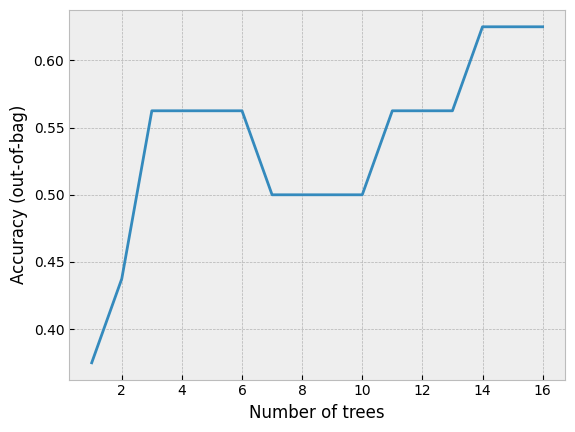

In [24]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()